In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("poster")
sns.set_style("ticks")

from collections import Counter, defaultdict
from itertools import count, chain
import random
import math

import dynet as dy
import numpy as np

import pandas as pd

from gensim.models.word2vec import Word2Vec

from tqdm import tnrange, tqdm_notebook

In [2]:
# format of files: each line is "word1/tag2 word2/tag2 ..."
train_file="data/cleaned/train.BIEOU.tsv"
test_file="data/cleaned/dev.BIEOU.tsv"

MAX_LIK_ITERS = 3
SMALL_NUMBER = -1e10
MARGIN = 0


In [3]:
class Vocab:
    def __init__(self, w2i=None):
        if w2i is None: w2i = defaultdict(count(0).next)
        self.w2i = dict(w2i)
        self.i2w = {i:w for w,i in w2i.iteritems()}
    @classmethod
    def from_corpus(cls, corpus):
        w2i = defaultdict(count(0).next)
        for sent in corpus:
            [w2i[word] for word in sent]
        return Vocab(w2i)

    def size(self): 
        return len(self.w2i.keys())


In [4]:
BIO={
    "E": "I",
    "U": "B"
}
def read(fname, use_BIO=False, notypes=False):
    """
    Read a NER-tagged file where each line is of the form "word1 tag2\nword2 tag2 ..."
    Yields lists of the form [(word1,tag1), (word2,tag2), ...]
    """
    with file(fname) as fh:
        sent = []
        for line in fh:
            line = line.strip()
            if line == "":
                if sent:
                    yield sent
                sent = []
                continue
            if line:
                line = line.split("\t")
                if notypes:
                    line[1] = line[1][:1]
                if use_BIO:
                    tag = line[1]
                    if tag[0] in BIO:
                        line[1]=BIO[tag[0]] + tag[1:]
                line = tuple(line)
                sent.append(line)
    if sent:
        yield sent


In [5]:
train=list(read(train_file, notypes=True))
test=list(read(test_file, notypes=True))
print("Train: %s, Test: %s" % (len(train), len(test)))

Train: 2394, Test: 1000


In [6]:
print(train[2])

[("'", 'O'), ('Breaking', 'B'), ('Dawn', 'E'), ("'", 'O'), ('Returns', 'O'), ('to', 'O'), ('Vancouver', 'U'), ('on', 'O'), ('January', 'O'), ('11th', 'O'), ('http://bit.ly/dbDMs8', 'O')]


In [7]:
def getCharClass(c):
    if ord('A') <= ord(c) <= ord('Z'):
        return "C"
    if ord('z') <= ord(c) <= ord('z'):
        return "c"
    if ord('0') <= ord(c) <= ord('9'):
        return "n"
    return "p"
    
def get_words_golds(sent):
    return zip(*sent)

pd.DataFrame(zip(*get_words_golds(train[3])))

,0,1
0,@ls_n,O
1,perhaps,O
2,",",O
3,but,O
4,folks,O
5,may,O
6,find,O
7,something,O
8,in,O
9,the,O


In [8]:
words=[]
tags=[]
ortho_words=[]
chars=set()
ortho_chars=set()
wc=Counter()
for sent in train:
    for w,p in sent:
        tags.append(p)
        w_lower = w.lower()
        words.append(w_lower)
        chars.update([c for c in w])
        ortho_w = "".join([getCharClass(c) for c in w])
        ortho_words.append(ortho_w)
        ortho_chars.update([c for c in ortho_w])
        wc[w_lower]+=1
words.append("_UNK_")
words.append("_S_")
chars.add("<*>")

ortho_words.append("_UNK_")
ortho_words.append("_S_")
ortho_chars.add("<*>")


tags.append("_S_")

In [9]:
vw = Vocab.from_corpus([words]) # TODO Vocab
vc = Vocab.from_corpus([chars])

vwo = Vocab.from_corpus([ortho_words]) # TODO Vocab
vco = Vocab.from_corpus([ortho_chars])

vt = Vocab.from_corpus([tags])

UNK = vw.w2i["_UNK_"]
S_W = vw.w2i["_S_"]

UNK_O = vwo.w2i["_UNK_"]
S_W_O = vwo.w2i["_S_"]

S_T = vt.w2i["_S_"]

In [10]:
vt.w2i

{'B': 2, 'E': 3, 'I': 4, 'O': 0, 'U': 1, '_S_': 5}

In [11]:
nwords = vw.size()
nchars  = vc.size()

nwords_ortho = vwo.size()
nchars_ortho  = vco.size()

ntags  = vt.size()

In [12]:
print(nwords, nchars, nwords_ortho, nchars_ortho, ntags)

(9070, 93, 1155, 5, 6)


In [13]:
W_EMBED_SIZE=400
WO_EMBED_SIZE=50
C_EMBED_SIZE=30
TAG_EMBED_SIZE=10
CHAR_LSTM_OUTPUT_SIZE=200 # If it is seperate use a lower number
LSTM_INPUT_SIZE=W_EMBED_SIZE # + WO_EMBED_SIZE + 4*CHAR_LSTM_OUTPUT_SIZE
LSTM_OUTPUT_SIZE=100
MLP_H_INPUT_SIZE=2*LSTM_OUTPUT_SIZE
MLP_H_OUTPUT_SIZE=ntags

In [14]:
# DyNet Starts

model = dy.Model()
trainer = dy.AdamTrainer(model)

WORDS_LOOKUP = model.add_lookup_parameters((nwords, W_EMBED_SIZE))
CHARS_LOOKUP = model.add_lookup_parameters((nchars, C_EMBED_SIZE))

WORDS_ORTHO_LOOKUP = model.add_lookup_parameters((nwords_ortho, WO_EMBED_SIZE))
CHARS_ORTHO_LOOKUP = model.add_lookup_parameters((nchars_ortho, C_EMBED_SIZE))

TRANS_LOOKUP = model.add_lookup_parameters((ntags, ntags))
#p_t1  = model.add_lookup_parameters((ntags, TAG_EMBED_SIZE))

# MLP on top of biLSTM outputs 100 -> 32 -> ntags
pH = model.add_parameters((MLP_H_OUTPUT_SIZE, MLP_H_INPUT_SIZE))
pO = model.add_parameters((ntags, MLP_H_OUTPUT_SIZE))

# word-level LSTMs
fwdRNN = dy.LSTMBuilder(1, LSTM_INPUT_SIZE, LSTM_OUTPUT_SIZE, model) # layers, in-dim, out-dim, model
bwdRNN = dy.LSTMBuilder(1, LSTM_INPUT_SIZE, LSTM_OUTPUT_SIZE, model)

# char-level LSTMs
cFwdRNN = dy.LSTMBuilder(1, C_EMBED_SIZE, CHAR_LSTM_OUTPUT_SIZE, model)
cBwdRNN = dy.LSTMBuilder(1, C_EMBED_SIZE, CHAR_LSTM_OUTPUT_SIZE, model)
CHAR_ATTENTION = model.add_parameters((2*CHAR_LSTM_OUTPUT_SIZE, W_EMBED_SIZE))

coFwdRNN = dy.LSTMBuilder(1, C_EMBED_SIZE, CHAR_LSTM_OUTPUT_SIZE, model)
coBwdRNN = dy.LSTMBuilder(1, C_EMBED_SIZE, CHAR_LSTM_OUTPUT_SIZE, model)
CHARO_ATTENTION = model.add_parameters((2*CHAR_LSTM_OUTPUT_SIZE, W_EMBED_SIZE))

In [15]:
TWEET_WORD2VEC_EMBEDDINGS_PATH='/home/entity/Downloads/word2vec_twitter_model/word2vec_twitter_model.bin'
def process_wordvecs(filename, vw, WORDS_LOOKUP, dims=200):
    t_word2vec = Word2Vec.load_word2vec_format(filename,
                                           binary=True, unicode_errors="ignore")
    found_words = 0
    words_read = len(t_word2vec.vocab)
    for word, widx in vw.w2i.iteritems():
        if word in t_word2vec:
            found_words += 1
            embedding = t_word2vec[word]
            WORDS_LOOKUP.init_row(widx, embedding)
    print "Found embeddings for %s words, total read: %s" % (found_words, words_read)

In [16]:
GLOVE_EMBEDDINGS_PATH="/home/entity/Downloads/GloVe/glove.6B.300d.txt"
def process_glovevectors(filename, vw, WORDS_LOOKUP, dims=200):
    found_words = 0
    words_read = 0
    with open(filename) as fp:
        for line in fp:
            word, embedding = line.strip().split(" ", 1)
            words_read += 1
            word = word.lower()
            if word not in vw.w2i:
                continue
            found_words += 1
            try:
                embedding = map(float, embedding.split(" "))
            except:
                print "Found embeddings for %s words, total read: %s" % (found_words, words_read)
                print word, embedding
                raise
            widx = vw.w2i[word]
            WORDS_LOOKUP.init_row(widx, embedding)
    print "Found embeddings for %s words, total read: %s" % (found_words, words_read)

In [17]:
use_glove=False
use_w2v=True
if use_glove:
    process_glovevectors(GLOVE_EMBEDDINGS_PATH, vw, WORDS_LOOKUP, dims=W_EMBED_SIZE)
elif use_w2v:
    process_wordvecs(TWEET_WORD2VEC_EMBEDDINGS_PATH, vw, WORDS_LOOKUP, dims=W_EMBED_SIZE)
else:
    print "using random init"

Found embeddings for 6536 words, total read: 3039345


In [18]:
def word_rep_backoff(w, cf_init, cb_init, *args):
    w_lowered = w.lower()
    if wc[w_lowered] > 5:
        w_index = vw.w2i[w_lowered]
        return WORDS_LOOKUP[w_index]
    else:
        pad_char = vc.w2i["<*>"]
        char_ids = [pad_char] + [vc.w2i[getCharClass(c)] for c in w] + [pad_char]
        char_embs = [CHARS_LOOKUP[cid] for cid in char_ids]
        fw_exps = cf_init.transduce(char_embs)
        bw_exps = cb_init.transduce(reversed(char_embs))
        return dy.concatenate([ fw_exps[-1], bw_exps[-1] ])
    
    
def word_rep_all(w, cf_init, cb_init, cof_init, cob_init):
    w_lowered = w.lower()
    if w_lowered in wc and wc[w_lowered] > 5:
        w_index = vw.w2i[w_lowered]
    else:
        w_index = UNK
    w_embed = WORDS_LOOKUP[w_index]
    ## Add ortho word embeddings
    ortho_w = "".join([getCharClass(c) for c in w])
    if ortho_w in vwo.w2i:
        w_index = vwo.w2i[ortho_w]
    else:
        w_index = UNK_O
    wo_embed = WORDS_ORTHO_LOOKUP[w_index]
    ## Add char embeddings
    pad_char = vc.w2i["<*>"]
    char_ids = [pad_char] + [vc.w2i[c] for c in w] + [pad_char]
    char_embs = [CHARS_LOOKUP[cid] for cid in char_ids]
    fw_exps = cf_init.transduce(char_embs)
    bw_exps = cb_init.transduce(reversed(char_embs))
    
    ## Add char ortho embeddings
    pad_char = vco.w2i["<*>"]
    char_ids = [pad_char] + [vco.w2i[c] for c in ortho_w] + [pad_char]
    char_embs = [CHARS_ORTHO_LOOKUP[cid] for cid in char_ids]
    fwo_exps = cof_init.transduce(char_embs)
    bwo_exps = cob_init.transduce(reversed(char_embs))
    
    return dy.concatenate([w_embed, fw_exps[-1], bw_exps[-1],
                          wo_embed, fwo_exps[-1], bwo_exps[-1],])



def word_rep_attention(w, cf_init, cb_init, cof_init, cob_init):
    w_lowered = w.lower()
    if w_lowered in wc and wc[w_lowered] > 5:
        w_index = vw.w2i[w_lowered]
    else:
        w_index = UNK
    w_embed = WORDS_LOOKUP[w_index]
    ## Add ortho word embeddings
    ortho_w = "".join([getCharClass(c) for c in w])
    if ortho_w in vwo.w2i:
        w_index = vwo.w2i[ortho_w]
    else:
        w_index = UNK_O
    wo_embed = WORDS_ORTHO_LOOKUP[w_index]
    ## Add char embeddings
    pad_char = vc.w2i["<*>"]
    char_ids = [pad_char] + [vc.w2i[c] for c in w] + [pad_char]
    char_embs = [CHARS_LOOKUP[cid] for cid in char_ids]
    fw_exps = cf_init.transduce(char_embs)
    bw_exps = cb_init.transduce(reversed(char_embs))
    char_full_exps = [dy.concatenate([fw, bw]) for fw, bw in zip(fw_exps, bw_exps)]
    ATT = dy.parameter(CHAR_ATTENTION)
    #(dy.transpose(clp[1])*(A*e))
    attn_w = dy.concatenate([dy.tanh(dy.transpose(cw)*(ATT*w_embed)) for cw in char_full_exps])
    attn_w = dy.softmax(attn_w)
    final_embed = []
    for awi, cw in enumerate(char_full_exps):
        final_embed.append(cw*attn_w[awi])
    final_embed = dy.esum(final_embed)
    
    
    ## Add char ortho embeddings
    pad_char = vco.w2i["<*>"]
    char_ids = [pad_char] + [vco.w2i[c] for c in ortho_w] + [pad_char]
    char_embs = [CHARS_ORTHO_LOOKUP[cid] for cid in char_ids]
    fwo_exps = cof_init.transduce(char_embs)
    bwo_exps = cob_init.transduce(reversed(char_embs))
    
    char_full_exps = [dy.concatenate([fw, bw]) for fw, bw in zip(fwo_exps, bwo_exps)]
    ATT = dy.parameter(CHARO_ATTENTION)
    #(dy.transpose(clp[1])*(A*e))
    attn_w = dy.concatenate([dy.tanh(dy.transpose(cw)*(ATT*w_embed)) for cw in char_full_exps])
    attn_w = dy.softmax(attn_w)
    final_embed_o = dy.esum([cw*attn_w[awi] for awi, cw in enumerate(char_full_exps)])
    
    return dy.concatenate([w_embed, final_embed,
                          wo_embed, final_embed_o,])


In [19]:
def build_tagging_graph(words, word_rep=word_rep_backoff):
    dy.renew_cg()
    # parameters -> expressions
    H = dy.parameter(pH)
    O = dy.parameter(pO)

    # initialize the RNNs
    f_init = fwdRNN.initial_state()
    b_init = bwdRNN.initial_state()

    cf_init = cFwdRNN.initial_state()
    cb_init = cBwdRNN.initial_state()
    
    cof_init = coFwdRNN.initial_state()
    cob_init = coBwdRNN.initial_state()

    # get the word vectors. word_rep(...) returns a 128-dim vector expression for each word.
    wembs = [word_rep(w, cf_init, cb_init, cof_init, cob_init) for w in words]
    wembs = [dy.dropout(we,0.5) for we in wembs] # optional

    # feed word vectors into biLSTM
    fw_exps = f_init.transduce(wembs)
    bw_exps = b_init.transduce(reversed(wembs))
# OR
#    fw_exps = []
#    s = f_init
#    for we in wembs:
#        s = s.add_input(we)
#        fw_exps.append(s.output())
#    bw_exps = []
#    s = b_init
#    for we in reversed(wembs):
#        s = s.add_input(we)
#        bw_exps.append(s.output())

    # biLSTM states
    bi_exps = [dy.concatenate([f,b]) for f,b in zip(fw_exps, reversed(bw_exps))]

    # feed each biLSTM state to an MLP
    exps = []
    for bi in bi_exps:
        bi = dy.dropout(bi,0.5)
        r_t = O*(dy.tanh(H * bi))
        exps.append(r_t)

    return exps

In [20]:
def viterbi_decoding(vecs, gold_tags = []):
    # Initialize
    init_prob = [SMALL_NUMBER] * ntags
    init_prob[S_T] = 0
    for_expr = dy.inputVector(init_prob)
    best_ids = []
    trans_exprs = [TRANS_LOOKUP[tid] for tid in range(ntags)]
    # Perform the forward pass through the sentence
    for i, vec in enumerate(vecs):
        my_best_ids = []
        my_best_exprs = []
        for next_tag in range(ntags):
            # Calculate vector for single next tag
            next_single_expr = for_expr + trans_exprs[next_tag]
            next_single = next_single_expr.npvalue()
            # Find and save the best score
            my_best_id = np.argmax(next_single)
            my_best_ids.append(my_best_id)
            my_best_exprs.append(dy.pick(next_single_expr, my_best_id))
        # Concatenate the scores for all vectors together
        for_expr = dy.concatenate(my_best_exprs) + vec
        # Give a bonus to all but the correct tag if using margin
        if MARGIN != 0 and len(gold_tags) != 0:
            adjust = [MARGIN] * ntags
            adjust[vt.w2i[gold_tags[i]]] = 0
            for_expr = for_expr + dy.inputVector(adjust)
        # Save the best ids
        best_ids.append(my_best_ids)
    # Perform the final step to the sentence terminal symbol
    next_single_expr = for_expr + trans_exprs[S_T]
    next_single = next_single_expr.npvalue()
    my_best_id = np.argmax(next_single)
    best_expr = dy.pick(next_single_expr, my_best_id)
    # Perform the reverse pass
    best_path = [vt.i2w[my_best_id]]
    for my_best_ids in reversed(best_ids):
        my_best_id = my_best_ids[my_best_id]
        best_path.append(vt.i2w[my_best_id])
    best_path.pop() # Remove final <s>
    best_path.reverse()
    # Return the best path and best score as an expression
    return best_path, best_expr

def forced_decoding(vecs, tags):
    # Initialize
    for_expr = dy.scalarInput(0)
    for_tag = S_T
    # Perform the forward pass through the sentence
    for i, vec in enumerate(vecs): 
        my_tag = vt.w2i[tags[i]]
        for_expr = for_expr + dy.pick(TRANS_LOOKUP[my_tag], for_tag) + vec[my_tag]
        for_tag = my_tag
    for_expr = for_expr + dy.pick(TRANS_LOOKUP[S_T], for_tag)
    return for_expr

def viterbi_sent_loss(vecs, tags):
    #vecs = build_tagging_graph(words)
    viterbi_tags, viterbi_score = viterbi_decoding(vecs, tags)
    if viterbi_tags != tags:
        reference_score = forced_decoding(vecs, tags)
        return viterbi_score - reference_score
    else:
        return dy.scalarInput(0)

def sent_loss(vecs, tags):
    #vecs = build_tagging_graph(words)
    errs = []
    for v,t in zip(vecs,tags):
        tid = vt.w2i[t]
        err = dy.pickneglogsoftmax(v, tid)
        errs.append(err)
    return dy.esum(errs)

def tag_sent(vecs):
    #vecs = build_tagging_graph(words)
    vecs = [dy.softmax(v) for v in vecs]
    probs = [v.npvalue() for v in vecs]
    tags = []
    for prb in probs:
        tag = np.argmax(prb)
        tags.append(vt.i2w[tag])
    return tags

def predict(sent, viterbi=True, word_rep=word_rep_backoff):
    words, golds = get_words_golds(sent)
    vecs = build_tagging_graph(words, word_rep=word_rep)
    if viterbi:
        tags, loss_exp = viterbi_decoding(vecs)
    else:
        tags = tag_sent(vecs)
    return tags

def print_sequences(sequences, predictions, filename, test_data=False, notypes=False):
    with open(filename, "wb+") as fp:
        for seq, pred in zip(sequences, predictions):
            for t, p in zip(seq, pred):
                token, tag = t
                if tag[0] == "U":
                    tag = "B%s" % tag[1:]
                if tag[0] == "E":
                    tag = "I%s" % tag[1:]
                if p[0] == "U":
                    p = "B%s" % p[1:]
                if p[0] == "E":
                    p = "I%s" % p[1:]
                if notypes:
                    tag = tag[0]
                    p = p[0]
                if test_data:
                    line = "\t".join((token, p))
                else:
                    line = "\t".join((token, tag, p))
                print >> fp, line
            print >> fp, ""
    print "Done"

In [21]:
num_tagged = cum_loss = 0
token_scores = []
sent_scores = []
avg_loss = []
word_rep=word_rep_backoff
for ITER in tnrange(10, desc="Iterations"):
    random.shuffle(train)
    for i,s in enumerate(tqdm_notebook(train, desc="Training Items", leave=False),
                         start=1):
        if i % 500 == 0:
            trainer.status()
            avg_loss.append(cum_loss / num_tagged)
            cum_loss = 0
            num_tagged = 0
        if i % 10000 == 0 or i == len(train)-1: 
            good_sent = bad_sent = good = bad = 0.0
            for sent in tqdm_notebook(test, desc="Test instances", leave=False):
                words, golds = get_words_golds(sent)
                vecs = build_tagging_graph(words, word_rep=word_rep)
                if ITER < MAX_LIK_ITERS:
                    tags = tag_sent(vecs)
                else:
                    tags, loss_exp = viterbi_decoding(vecs)
                if tags == golds: good_sent += 1
                else: bad_sent += 1
                for go,gu in zip(golds,tags):
                    if go == gu: good += 1
                    else: bad += 1
            #print good/(good+bad), good_sent/(good_sent+bad_sent)
            token_scores.append(good/(good+bad))
            sent_scores.append(good_sent/(good_sent+bad_sent))
        # train on sent
        words, golds = get_words_golds(s)
        vecs = build_tagging_graph(words, word_rep=word_rep)
        if ITER < MAX_LIK_ITERS:
            loss_exp =  sent_loss(vecs, golds)
        else:
            loss_exp =  viterbi_sent_loss(vecs, golds)
        cum_loss += loss_exp.scalar_value()
        num_tagged += len(golds)
        loss_exp.backward()
        trainer.update()
    #print "epoch %r finished" % ITER
    trainer.update_epoch(1.0)

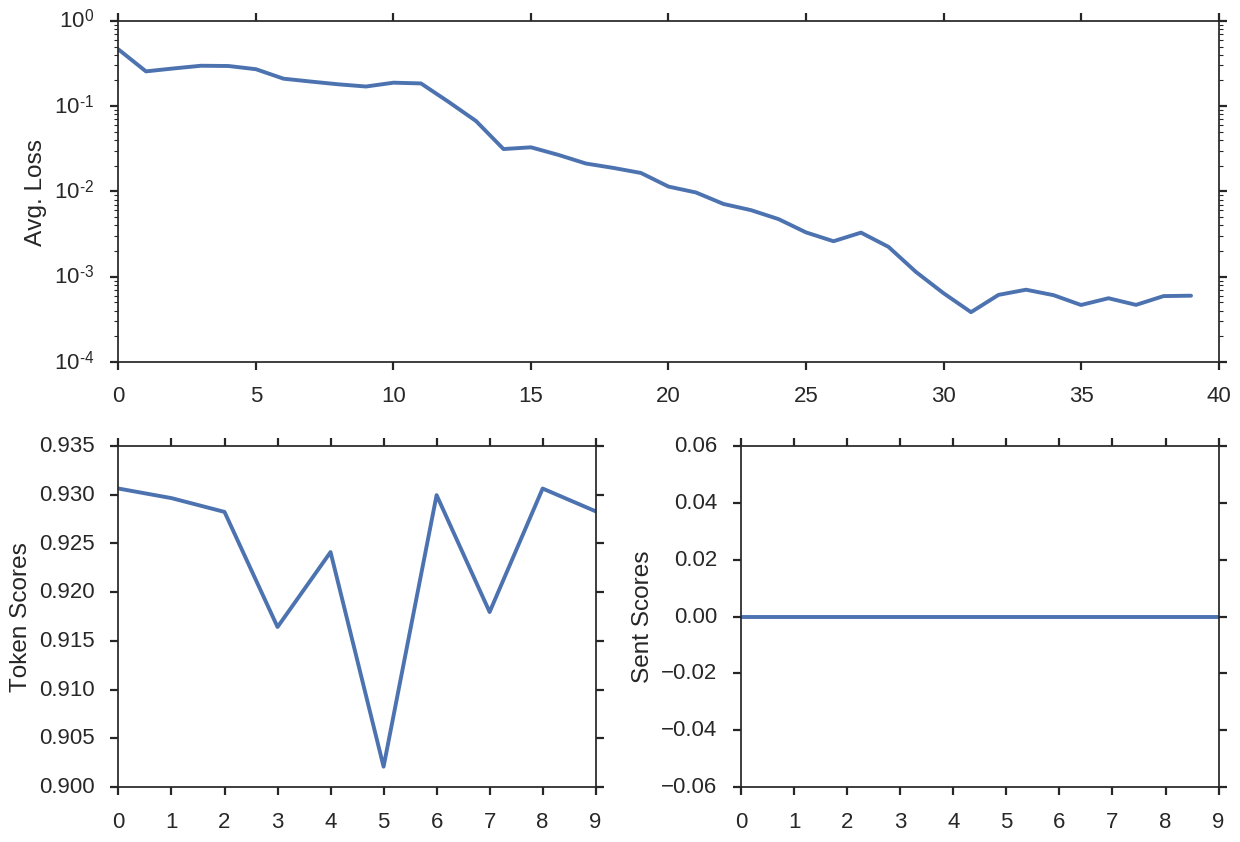

In [22]:
ax = plt.subplot2grid((2,2), (0,0), colspan=2)
ax.plot(avg_loss)
ax.set_ylabel("Avg. Loss")
ax.set_yscale("log")
ax = plt.subplot2grid((2,2), (1,0))
ax.plot(token_scores)
ax.set_ylabel("Token Scores")
ax = plt.subplot2grid((2,2), (1,1))
ax.plot(sent_scores)
ax.set_ylabel("Sent Scores")
plt.tight_layout()

In [23]:
zip(test[2], predict(test[2], word_rep=word_rep))

[(('RT', 'O'), 'O'),
 (('@shashiranjanttv', 'O'), 'O'),
 ((':', 'O'), 'O'),
 (('@shashiranjanttv', 'O'), 'O'),
 (('second', 'O'), 'O'),
 (('is', 'O'), 'O'),
 (('Bawana', 'U'), 'O'),
 (('constituency', 'O'), 'O'),
 (('on', 'O'), 'O'),
 (('Feb', 'O'), 'O'),
 (('4', 'O'), 'O'),
 (('-', 'O'), 'O'),
 (('Final', 'O'), 'O')]

In [24]:
print_sequences(train, [predict(s,word_rep=word_rep) for s in train], "train.dynet.tsv")
! cat train.dynet.tsv | tr '\t' ' ' | perl -ne '{chomp;s/\r//g;print $_,"\n";}' | python data/conlleval.py

Done
processed 46469 tokens with 1499 phrases; found: 214 phrases; correct: 117.
accuracy:  95.08%; precision:  54.67%; recall:   7.81%; FB1:  13.66
                 : precision:  54.67%; recall:   7.81%; FB1:  13.66  214


In [25]:
print_sequences(test, [predict(s,word_rep=word_rep) for s in test], "test.dynet.tsv")

Done


In [26]:
! cat test.dynet.tsv | tr '\t' ' ' | perl -ne '{chomp;s/\r//g;print $_,"\n";}' | python data/conlleval.py

processed 16261 tokens with 665 phrases; found: 69 phrases; correct: 17.
accuracy:  92.98%; precision:  24.64%; recall:   2.56%; FB1:   4.63
                 : precision:  24.64%; recall:   2.56%; FB1:   4.63  69


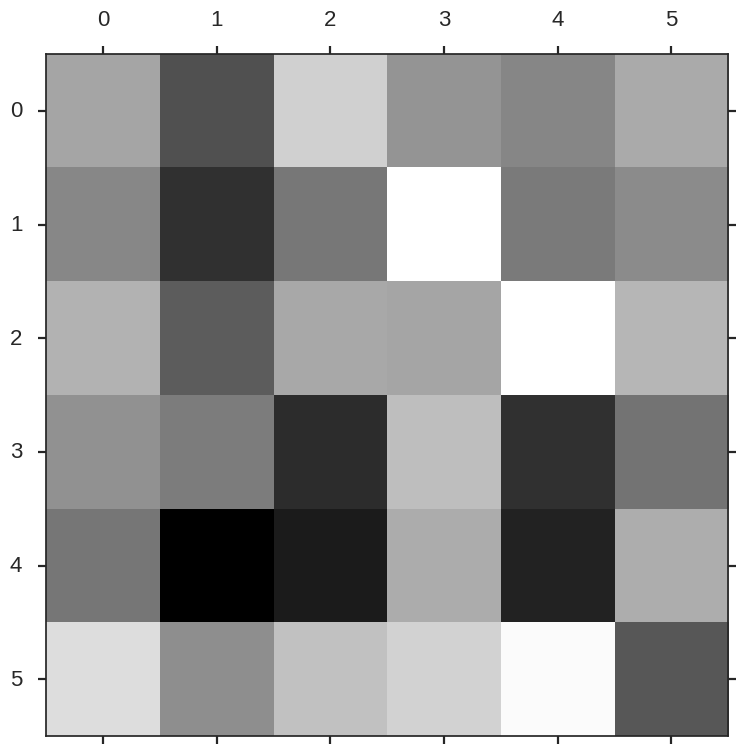

In [27]:
plt.matshow(TRANS_LOOKUP.as_array())

In [28]:
vt.i2w

{0: 'O', 1: 'U', 2: 'B', 3: 'E', 4: 'I', 5: '_S_'}

In [29]:
sorted_ids = np.array([vt.w2i[t] for t in sorted(vt.i2w.values(), key=lambda x: x[2:] + x[:2])])
sorted_ids.shape

(6,)

In [30]:
TRANS_LOOKUP.as_array()[sorted_ids][:, sorted_ids].shape

(6, 6)

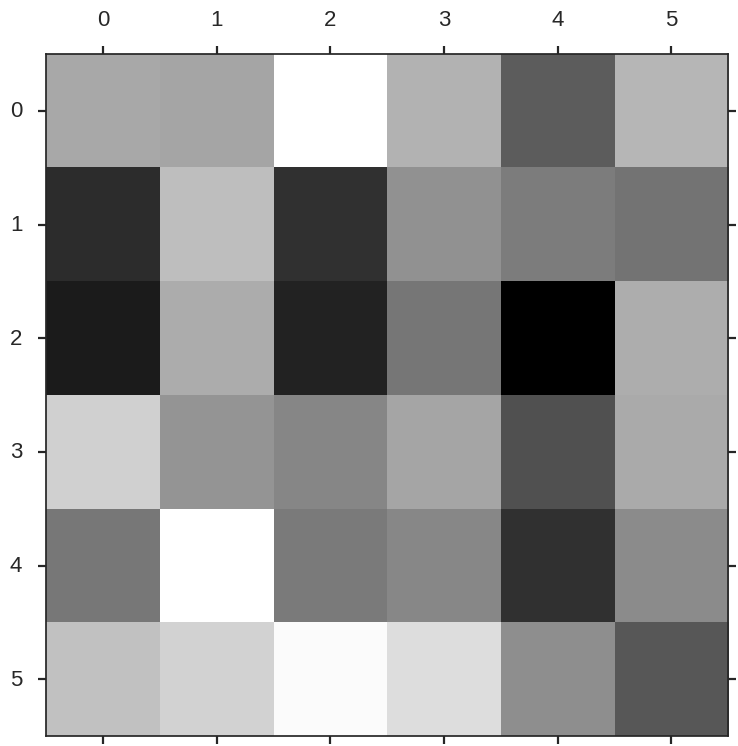

In [31]:
plt.matshow(TRANS_LOOKUP.as_array()[sorted_ids][:, sorted_ids])

In [32]:
TRANS_LOOKUP.shape()

(6, 6)